In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1D',
         'start_date':20170601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

8.469383955001831


In [2]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [3]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [4]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [5]:
def RankPct(df):
    return df.rank(axis=0, pct=True)
def Scale(df,k=1):
    return df.mul(k).div(np.abs(df).sum())

In [6]:
alpha60 = dv.add_formula('alpha60_C','(0-(1*((2*Scale(RankPct(((((close - low) - (high - close)) / (high - low)) * volume))))-Scale(RankPct(Ts_Argmax(close, 10))))))',add_data=True, register_funcs={'RankPct':RankPct, 'Scale':Scale})

In [7]:
alpha60_plot = dv.get_ts('alpha60_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

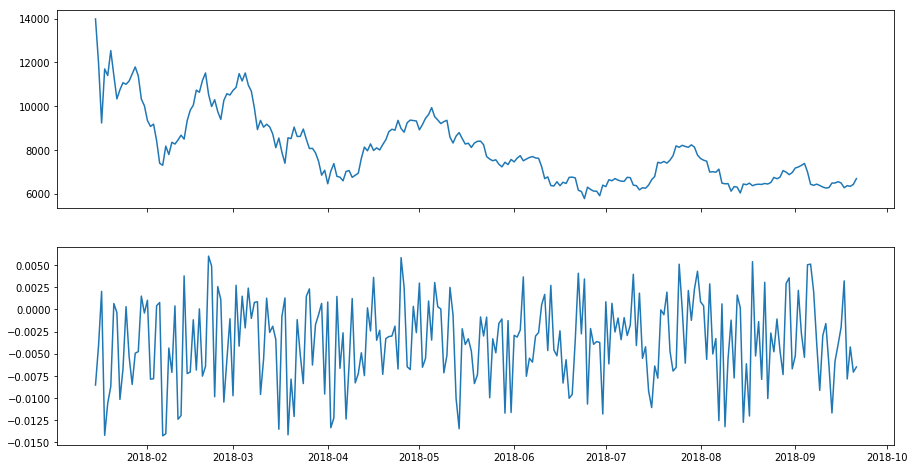

In [8]:
plot_chart(close, alpha60_plot)

alpha60因子在因子值最小的时候close的价格处于波段价格的低点

In [9]:
alpha1=dv.add_formula('alpha1_C','RankPct(Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5))',add_data=True, register_funcs={'RankPct':RankPct})

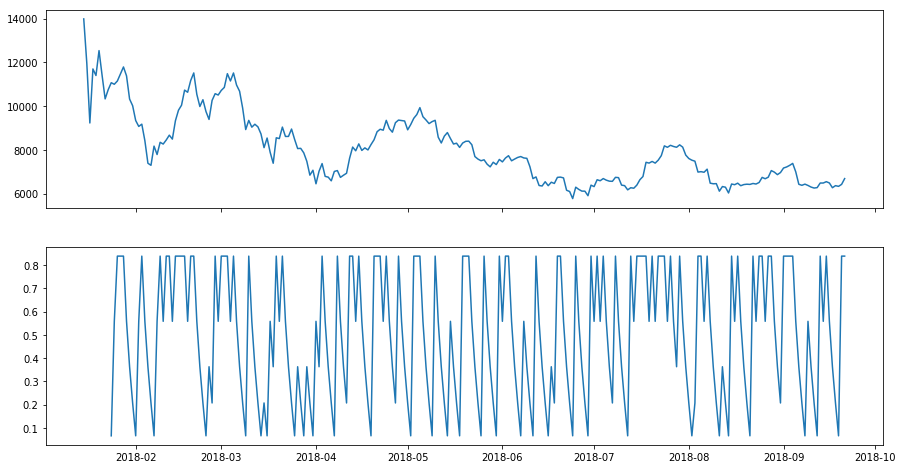

In [10]:
alpha1_plot = dv.get_ts('alpha1_C', date_type='datetime')
plot_chart(close, alpha1_plot)

当close之前的走势是下降时，alpha1的因子处于极值的时候就会发生反转向上的信号，当close之前的走势的上升时，alpha1的因子值处于极值的时候就会发生
反转向下的信号

In [11]:
data1D = Time_dict.set_index('datetime')

In [12]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1D.index, data1D.volume)
    plt.show()

In [13]:
from matplotlib.pylab import date2num

data1D['candleTime'] = list(map(date2num, data1D.index))
candle = data1D.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

alpha60因子的值在最小的时候，很多时候close都是处于比较低的状态，此时买压很重，之后会引起一波反转，所以入场信号是当alpha60因子值处于近5日以来
因子值的最低点，那么就买入，出场信号是当alpha60因子值处于近5日以来因子值的最高点，那么就卖出

In [14]:
Long = dv.add_formula('Long','If(alpha60_C ==Ts_Min(alpha60_C,5), 2, 0)', add_data=True)
Short = dv.add_formula('Short','If(alpha60_C ==Ts_Max(alpha60_C,5), -2, 0)', add_data=True)

close_long = dv.add_formula("closeLong","If(Short==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShort","If(Long==2,-1,0)", add_data=True)

In [15]:
Long = dv.get_ts('Long', date_type='datetime')

In [16]:
Long[Long['BTCUSDT:binance']==2].index

DatetimeIndex(['2018-01-15', '2018-01-18', '2018-02-02', '2018-02-06',
               '2018-02-19', '2018-02-23', '2018-02-26', '2018-03-10',
               '2018-03-16', '2018-03-19', '2018-03-31', '2018-04-02',
               '2018-04-07', '2018-04-19', '2018-04-24', '2018-04-28',
               '2018-05-09', '2018-05-13', '2018-05-14', '2018-05-19',
               '2018-05-24', '2018-05-29', '2018-06-05', '2018-06-12',
               '2018-06-15', '2018-06-17', '2018-06-19', '2018-06-25',
               '2018-06-30', '2018-07-11', '2018-07-13', '2018-07-15',
               '2018-07-16', '2018-07-23', '2018-08-03', '2018-08-07',
               '2018-08-09', '2018-08-15', '2018-08-23', '2018-08-28',
               '2018-09-09', '2018-09-13', '2018-09-18'],
              dtype='datetime64[ns]', name='trade_date', freq=None)

In [17]:
scatterX = Long[Long['BTCUSDT:binance']==2].index

In [18]:
scatterY = data1D.loc[scatterX].low-100

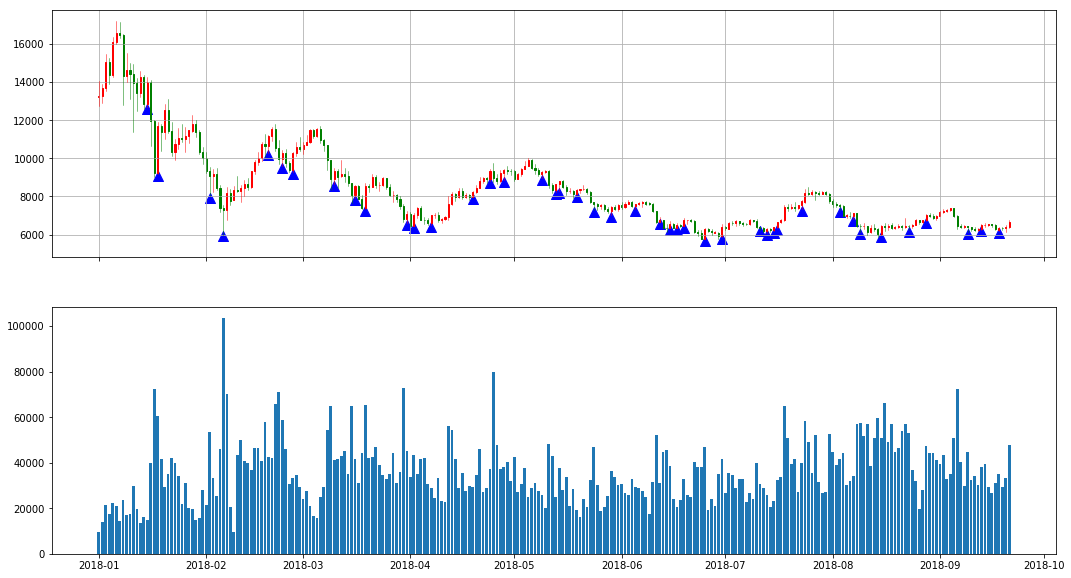

In [19]:
draw_candle(candle, scatterX, scatterY)

In [20]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

td = TimingDigger(output_folder=".", output_format='pdf',signal_name='alpha60')

def TimingSignal(td, dv, long='Long', short='Short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

F:\Anaconda\envs\dayu\lib\site-packages\jaqs\research\signaldigger\plotting.py:10: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')
F:\Anaconda\envs\dayu\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [21]:
TimingSignal(td, dv, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 16%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 18%


In [22]:
td.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.968  -6.271  -0.201
p-value              0.000   0.000   0.842
mean                 0.083  -0.056  -0.003
std                  0.065   0.044   0.086
info_ratio           1.283  -1.254  -0.031
skewness             0.548  -2.153   0.494
kurtosis            -0.709   6.474   0.676
pct5                 0.001  -0.093  -0.090
pct25                0.034  -0.079  -0.057
pct50                0.078  -0.054  -0.019
pct75                0.109  -0.023   0.045
pct95                0.199  -0.007   0.174
occurance           16.000  26.000  42.000
win_ratio              NaN     NaN   0.381
win_mean/loss_mean     NaN     NaN   1.498


In [23]:
td.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.651  -6.577   1.049
p-value              0.000   0.000   0.300
mean                 0.077  -0.053   0.013
std                  0.065   0.038   0.084
info_ratio           1.178  -1.402   0.155
skewness             0.700  -0.876   0.560
kurtosis            -0.668   0.498  -0.112
pct5                 0.004  -0.113  -0.102
pct25                0.021  -0.066  -0.051
pct50                0.063  -0.051   0.001
pct75                0.121  -0.020   0.063
pct95                0.200  -0.007   0.184
occurance           24.000  23.000  47.000
win_ratio              NaN     NaN   0.511
win_mean/loss_mean     NaN     NaN   1.437


In [24]:
td.create_event_report(sig_type="long_short") #同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               7.610  -9.105   0.618
p-value              0.000   0.000   0.538
mean                 0.079  -0.055   0.006
std                  0.065   0.042   0.085
info_ratio           1.219  -1.314   0.066
skewness             0.637  -1.715   0.517
kurtosis            -0.696   4.772   0.276
pct5                 0.001  -0.111  -0.096
pct25                0.024  -0.074  -0.054
pct50                0.070  -0.052  -0.010
pct75                0.120  -0.020   0.054
pct95                0.201  -0.006   0.188
occurance           40.000  49.000  89.000
win_ratio              NaN     NaN   0.449
win_mean/loss_mean     NaN     NaN   1.454


upperBand = MA_j + ATR，lowBand = MA_j - ATR,当close大于upperBand时买压开始加重，买入，当close小于lowBand时卖压开始加重，卖出，

In [25]:
MA_j = dv.add_formula('MA_j', "Ts_Mean(close,5)", add_data=True)
ATR = dv.add_formula('ATR', "Ta('ATR',0,0,high,low,close,0,10)",  add_data=True)
upperBand = dv.add_formula('upperBand','MA_j + ATR',add_data=True)
lowBand = dv.add_formula('lowBand','MA_j - ATR',add_data=True)
Long1 = dv.add_formula('Long1','If(close>upperBand, 2, 0)', add_data=True)
Short1 = dv.add_formula('Short1','If(close<lowBand, -2, 0)', add_data=True)

close_long = dv.add_formula("closeLong1","If(Short1==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShort1","If(Long1==2,-1,0)", add_data=True)

In [26]:
td1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='ATR')
TimingSignal(td1, dv, long='Long1', short='Short1',closeLong='closeLong1', closeShort='closeShort1',mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 7%


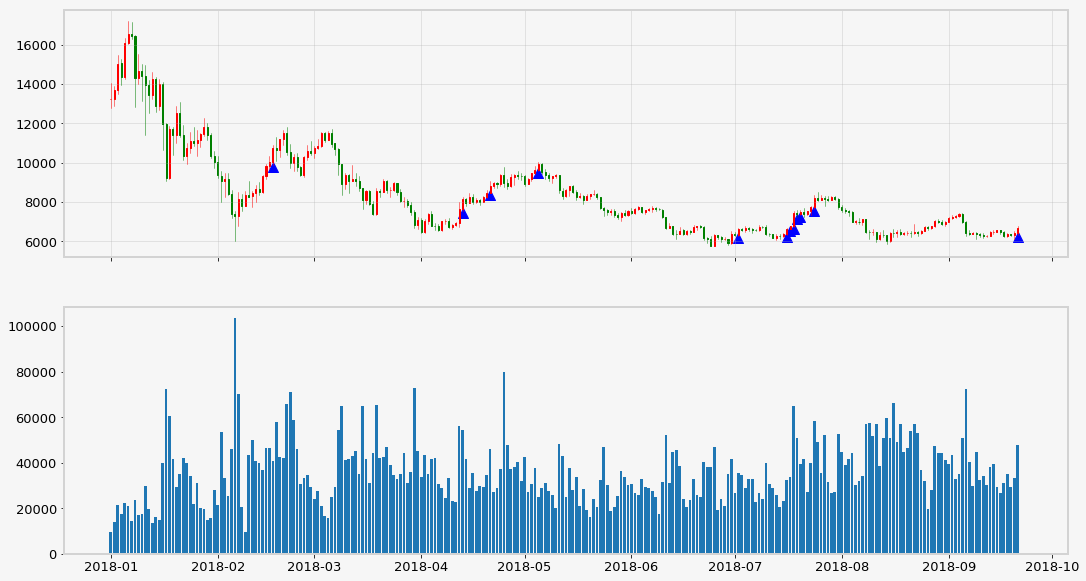

In [27]:
Long = dv.get_ts('Long1', date_type='datetime')
scatterX = Long[Long['BTCUSDT:binance']==2].index
scatterY = data1D.loc[scatterX].low-100
draw_candle(candle, scatterX, scatterY)

In [28]:
td1.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              2.171 -10.396  -0.738
p-value             0.082   0.000   0.478
mean                0.034  -0.072  -0.014
std                 0.036   0.014   0.060
info_ratio          0.971  -5.198  -0.233
skewness            1.407  -1.339   0.418
kurtosis            0.402   0.006  -0.699
pct5                0.008  -0.094  -0.085
pct25               0.013  -0.071  -0.064
pct50               0.017  -0.064   0.007
pct75               0.037  -0.064   0.017
pct95               0.093  -0.063   0.077
occurance           6.000   5.000  11.000
win_ratio             NaN     NaN   0.545
win_mean/loss_mean    NaN     NaN   0.478


In [29]:
td1.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              3.115 -16.515   0.342
p-value             0.021   0.000   0.736
mean                0.148  -0.070   0.010
std                 0.117   0.014   0.127
info_ratio          1.272  -4.979   0.081
skewness            0.526  -0.568   1.444
kurtosis           -1.192  -1.222   0.906
pct5                0.017  -0.093  -0.092
pct25               0.067  -0.081  -0.070
pct50               0.121  -0.065  -0.058
pct75               0.220  -0.059   0.067
pct95               0.324  -0.055   0.312
occurance           7.000  12.000  19.000
win_ratio             NaN     NaN   0.368
win_mean/loss_mean    NaN     NaN   2.111


In [30]:
td1.create_event_report(sig_type="long_short") #同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.145 -20.134   0.069
p-value              0.008   0.000   0.946
mean                 0.096  -0.071   0.001
std                  0.105   0.014   0.108
info_ratio           0.908  -5.033   0.013
skewness             1.276  -0.780   1.681
kurtosis             0.353  -0.791   2.337
pct5                 0.010  -0.095  -0.093
pct25                0.017  -0.079  -0.066
pct50                0.044  -0.064  -0.056
pct75                0.121  -0.060   0.023
pct95                0.318  -0.055   0.229
occurance           13.000  17.000  30.000
win_ratio              NaN     NaN   0.433
win_mean/loss_mean     NaN     NaN   1.353


In [31]:
Long = dv.add_formula('Long','If((Delta(close,5)<0) && ((alpha1_C ==Ts_Min(alpha1_C,5))||(alpha1_C ==Ts_Max(alpha1_C,5))), 2, 0)', add_data=True)
Short = dv.add_formula('Short','If((Delta(close,5)>0) && ((alpha1_C ==Ts_Min(alpha1_C,5))||(alpha1_C ==Ts_Max(alpha1_C,5))), -2, 0)', add_data=True)

close_long = dv.add_formula("closeLong","If(Short==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShort","If(Long==2,-1,0)", add_data=True)

Field [Long] is overwritten.
Field [Short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [32]:
td1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='alpha1')
TimingSignal(td1, dv, long='Long', short='Short',closeLong='closeLong', closeShort='closeShort',mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 28%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 35%


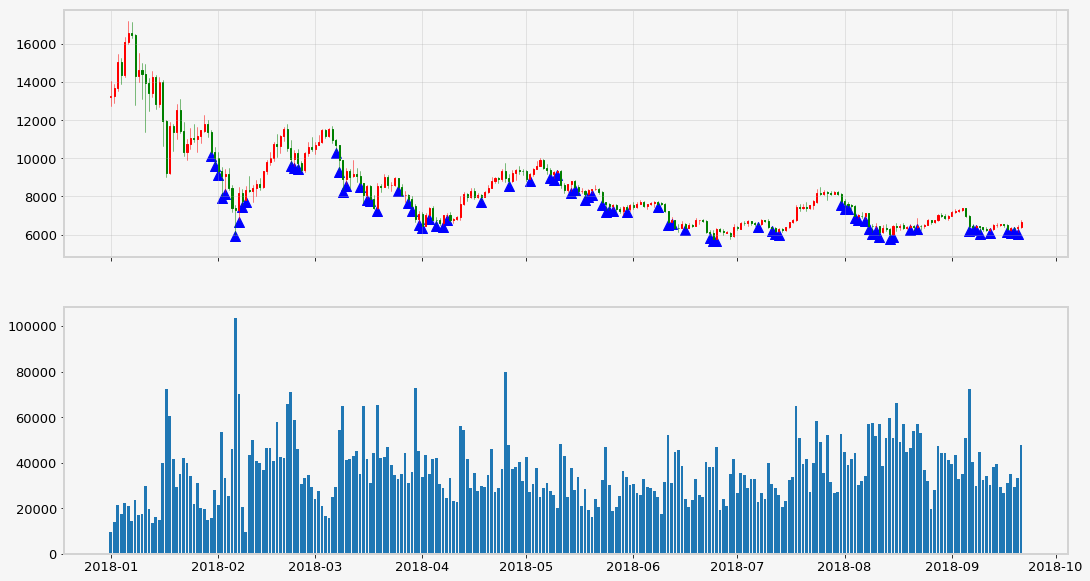

In [33]:
Long = dv.get_ts('Long', date_type='datetime')
scatterX = Long[Long['BTCUSDT:binance']==2].index
scatterY = data1D.loc[scatterX].low-100
draw_candle(candle, scatterX, scatterY)

In [34]:
td1.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               6.509 -11.283  -0.938
p-value              0.000   0.000   0.351
mean                 0.057  -0.056  -0.007
std                  0.049   0.032   0.069
info_ratio           1.169  -1.741  -0.109
skewness             1.302   0.213   0.722
kurtosis             1.171  -0.910   0.224
pct5                 0.007  -0.100  -0.095
pct25                0.017  -0.077  -0.066
pct50                0.043  -0.063  -0.010
pct75                0.075  -0.020   0.034
pct95                0.158  -0.005   0.115
occurance           32.000  43.000  75.000
win_ratio              NaN     NaN   0.427
win_mean/loss_mean     NaN     NaN   1.028


In [35]:
td1.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat              10.057 -11.775   0.442
p-value              0.000   0.000   0.659
mean                 0.069  -0.052   0.003
std                  0.044   0.031   0.071
info_ratio           1.571  -1.682   0.046
skewness            -0.001  -0.373   0.337
kurtosis            -1.123  -0.824  -0.964
pct5                 0.003  -0.105  -0.098
pct25                0.024  -0.068  -0.057
pct50                0.071  -0.052  -0.010
pct75                0.104  -0.028   0.064
pct95                0.139  -0.010   0.129
occurance           42.000  50.000  92.000
win_ratio              NaN     NaN   0.457
win_mean/loss_mean     NaN     NaN   1.329


In [36]:
td1.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              11.734 -16.369   -0.285
p-value              0.000   0.000    0.776
mean                 0.064  -0.054   -0.002
std                  0.047   0.031    0.070
info_ratio           1.373  -1.707   -0.022
skewness             0.614  -0.093    0.504
kurtosis            -0.230  -0.926   -0.510
pct5                 0.005  -0.103   -0.099
pct25                0.023  -0.074   -0.059
pct50                0.063  -0.057   -0.010
pct75                0.095  -0.024    0.053
pct95                0.142  -0.007    0.123
occurance           74.000  93.000  167.000
win_ratio              NaN     NaN    0.443
win_mean/loss_mean     NaN     NaN    1.191
